<a href="https://colab.research.google.com/github/es2mac/SwiftDigger/blob/master/TetrisField.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ideas

Next steps:
- Explore the value range of BCTS & scale
- Consider moving off notebook

MCTS:
- Start from root node, select best child until we find one that hasn't been evaluated
  - "Best" includes priors, and balances exploration & exploitation
  - Internally, this node is freshly initiated at this selection step
- Prepare this node for evaluation, and set up for possible future visits
  - Find all valid children
  - Based on the number of valid children, initiate children N, W
- Evaluate the node
  - Get value of this node, and set priors for its children
  - Backpropagate the value


Notes on crafting features:
- Simple value ideas (working thought below) didn't work well.  The bot plays too greedy and has no idea what to do if no line is cleared.  It can't see far enough.  Before moving to reinforcement learning, should try some known methods to see how it goes.
- In the end I implemented Thiery and Scherrer's BCTS, might be state-of-the-art?
- Dellacherie’s original evaluation: see the Thiery-Scherrer paper
- [El-Tetris](http://imake.ninja/el-tetris-an-improvement-on-pierre-dellacheries-algorithm/) [source code](https://github.com/daogan/tetris-ai/blob/master/tetris_ai.py) is also a good source of feature clarification


Working thought:

- An NN model needs to be able to handle 0~5 previews when doing MCTS for a real game that has 5 previews.  Cases with more previews seems more important, but cases with less previews are used far more often in that type of search (if time permits).  In fact, if we often get down to 3 previews or fewer (tree depth >2), maybe it's reasonable to shrink the model to only handle fewer previews?  On the other hand, with very few or no preview, there shouldn't be enough information to know with any certainty whether the next few lines could be cleared quickly.  It's very situational.

- Value function.  The general idea is "piece/line ratio."  One idea is that only garbage lines matter, don't reward clearing lines made with player pieces.  The other is whether we do 
  - How many pieces for the next N lines, or
  - How many lines for the next N pieces
  - Some complicated combo, fixing neither line nor piece count?

- Say I use the number of pieces for the next 4 garbage lines.  My value could be linear, or could be 4/n where the max value is 1.  Questions here:
  - Does this curve work well, in the context of UCT? (might need to try and see)
  - Does N=4 make sense?  4/4 is very possible, and the risk is whether this is too short-sighted.  On the other hand, if I use say N=10, the signal may be too weak because in such long-term, a single placement doesn't affect the final piece count very much.
  
- For RL's early stage, maybe I could set up a simplified problem, say given N=7 pieces (i.e. play, hold, and 5 previews), try to clear as many lines as possible.  Increase N once it gets off the ground.

References:
- Look at [this](http://www.moderndescartes.com/essays/deep_dive_mcts/) to think about MCTS tree node efficiency.
- [This series of medium posts](https://medium.com/oracledevs/lessons-from-alphazero-part-3-parameter-tweaking-4dceb78ed1e5) seems like a good resource about AlphaZero.
- See [MiniGo in Swift](https://github.com/tensorflow/swift-models/tree/master/MiniGo) 



# Setup

In [0]:
import Foundation
import Python
import TensorFlow

%include "EnableIPythonDisplay.swift"
_ = IPythonDisplay.shell.enable_matplotlib("inline")

// print(Python.version)

# Tetris Types

In [0]:
/// Just the type of a tetromino.
enum Tetromino: Int, CaseIterable {
  // The raw values are specified for easy composition in Piece hash
  case I = 0
  case J = 4
  case L = 8
  case O = 12
  case S = 16
  case T = 20
  case Z = 24
}

In [0]:
public func < <T: RawRepresentable>(a: T, b: T) -> Bool where T.RawValue: Comparable {
    return a.rawValue < b.rawValue
}

extension Tetromino: Comparable {}

In [0]:
/// A piece is a tetromino with placement information.  Calling it "Piece"
/// instead of "Placement" to be intentionally ambiguous, to use in different
/// contexts where we need to describe more than just the Tetromino type.
struct Piece {
  enum Orientation: Int, CaseIterable {
      case up, right, down, left
  }

  let type: Tetromino
  var x: Int
  var y: Int
  var orientation: Orientation = .up
}

extension Piece: Hashable {
  var hashValue: Int {
    return ((x + y * 10) << 5) | type.rawValue | orientation.rawValue
  }
}

In [0]:
/// The game field is really just an array of rows.
/// It can be any number of rows tall.
struct Field {
  /// Each row is stored as bits in an Int16.
  /// By convention, empty top rows should be removed, no empty row.
  internal var storage: [Int16]
  var height: Int { return storage.count }
  var garbageCount: Int
}

# Field Methods

### Construct bitmasks of piece for placement check

In [0]:
/**
"Unshifted" means additional x/y shifting needs to happen when using these.

 Because pieces extend to the left and down of the piece center, these masks
 uniformally start from 2 blocks left of the center, and starts from the
 bottom-most row of the piece.  An additional offset is constructed for where
 that bottom row is with respect to the piece center.

 In other words, when using these masks to check a piece on the field:
 1) Shift by piece's x position, then back 2 bits
 2) Shift by piece's y position, minus the bottom row offset

 Ref: https://harddrop.com/wiki/SRS
 */
func makeUnshiftedPieceBitmasks(type: Tetromino, orientation: Piece.Orientation) -> [Int16] {
  switch (type, orientation) {
    case (.I, .up)   : return [0b11110]
    case (.I, .right): return [0b100, 0b100, 0b100, 0b100]
    case (.I, .down) : return [0b1111]
    case (.I, .left) : return [0b100, 0b100, 0b100, 0b100]
    case (.J, .up)   : return [0b1110, 0b10]
    case (.J, .right): return [0b100, 0b100, 0b1100]
    case (.J, .down) : return [0b1000, 0b1110]
    case (.J, .left) : return [0b110, 0b100, 0b100]
    case (.L, .up)   : return [0b1110, 0b1000]
    case (.L, .right): return [0b1100, 0b100, 0b100]
    case (.L, .down) : return [0b10, 0b1110]
    case (.L, .left) : return [0b100, 0b100, 0b110]
    case (.O, .up)   : return [0b1100, 0b1100]
    case (.O, .right): return [0b1100, 0b1100]
    case (.O, .down) : return [0b110, 0b110]
    case (.O, .left) : return [0b110, 0b110]
    case (.S, .up)   : return [0b110, 0b1100]
    case (.S, .right): return [0b1000, 0b1100, 0b100]
    case (.S, .down) : return [0b110, 0b1100]
    case (.S, .left) : return [0b100, 0b110, 0b10]
    case (.T, .up)   : return [0b1110, 0b100]
    case (.T, .right): return [0b100, 0b1100, 0b100]
    case (.T, .down) : return [0b100, 0b1110]
    case (.T, .left) : return [0b100, 0b110, 0b100]
    case (.Z, .up)   : return [0b1100, 0b110]
    case (.Z, .right): return [0b100, 0b1100, 0b1000]
    case (.Z, .down) : return [0b1100, 0b110]
    case (.Z, .left) : return [0b10, 0b110, 0b100]
  }
}

In [0]:
func getBottomRowOffset(type: Tetromino, orientation: Piece.Orientation) -> Int {
  switch (type, orientation) {
    case (.I, .up)   : return 0
    case (.I, .right): return 2
    case (.I, .down) : return 0
    case (.I, .left) : return 1
    case (.J, .up)   : return 0
    case (.J, .right): return 1
    case (.J, .down) : return 1
    case (.J, .left) : return 1
    case (.L, .up)   : return 0
    case (.L, .right): return 1
    case (.L, .down) : return 1
    case (.L, .left) : return 1
    case (.O, .up)   : return 0
    case (.O, .right): return 1
    case (.O, .down) : return 1
    case (.O, .left) : return 0
    case (.S, .up)   : return 0
    case (.S, .right): return 1
    case (.S, .down) : return 1
    case (.S, .left) : return 1
    case (.T, .up)   : return 0
    case (.T, .right): return 1
    case (.T, .down) : return 1
    case (.T, .left) : return 1
    case (.Z, .up)   : return 0
    case (.Z, .right): return 1
    case (.Z, .down) : return 1
    case (.Z, .left) : return 1
  }
}

I'm unsure about the performance of this double enum switching, so I'm composing them into plain arrays with my own indexing scheme.

It might be interesting to compare the performance of calling the above functions vs. arrays.

In [0]:
extension Piece {
  /// This code is used as index to construct & access the constants arrays
  var typeAndOrientationCode: Int {
    get {
      return type.rawValue + orientation.rawValue
    }
  }
}


In [0]:
let unshiftedPieceBitmasks: [[Int16]] = { () -> [[Int16]] in
  var masks = [[Int16]](repeating: [], count: 7 * 4)
  for type in Tetromino.allCases {
    for orientation in Piece.Orientation.allCases {
      let piece = Piece(type: type, x: 0, y: 0, orientation: orientation)
      masks[piece.typeAndOrientationCode] = makeUnshiftedPieceBitmasks(type: type, orientation: orientation)
    }
  }
  return masks
}()

let unshiftedWholePieceBitmasks: [Int] = unshiftedPieceBitmasks.map { lineMasks in
  lineMasks.reversed().reduce(0, { (wholeMask, lineMask) in
    (wholeMask << 10) | Int(lineMask)
  })
}

let bottomRowOffsets: [Int] = { () -> [Int] in
  var offsets = [Int](repeating: 0, count: 7 * 4)
  for type in Tetromino.allCases {
    for orientation in Piece.Orientation.allCases {
      let piece = Piece(type: type, x: 0, y: 0, orientation: orientation)
      offsets[piece.typeAndOrientationCode] = getBottomRowOffset(type: type, orientation: orientation)
    }
  }
  return offsets  
}()

### Field string representation (for debugging)

In [0]:
extension Field: CustomDebugStringConvertible {
  public var debugDescription: String {
    var lines = storage.map { (n: Int16) -> String in
      let binaryString = String(n, radix: 2)
      let padding =  String(repeating: "0", count: (10 - binaryString.count))
      return padding + binaryString + "  "
    }
    if (garbageCount > 0) && (garbageCount <= lines.count) {
      lines[garbageCount - 1] = "==< " + lines[garbageCount - 1]
    }
    return String(lines.joined(separator: "\n").reversed())
             .replacingOccurrences(of: "0", with: ". ")
             .replacingOccurrences(of: "1", with: "X ")
  }
}

In [0]:
extension Piece: CustomDebugStringConvertible {
  public var debugDescription: String {
      let masks = unshiftedPieceBitmasks[typeAndOrientationCode]
      var lines = masks.map {
        String($0, radix: 2)
          .replacingOccurrences(of: "0", with: " ")
          .replacingOccurrences(of: "1", with: "X")
      }
    
        var joinedLines = String(lines.joined(separator: "\n").reversed())
      joinedLines += String(repeating: " ", count: 6 - lines.last!.count)
      joinedLines += "(\(x), \(y))\n"
      return "\n" + joinedLines
  }
}
  

In [0]:
extension Tetromino: CustomDebugStringConvertible {
  public var debugDescription: String {
    switch self {
      case .I: return "I"
      case .J: return "J"
      case .L: return "L"
      case .O: return "O"
      case .S: return "S"
      case .T: return "T"
      case .Z: return "Z"
    }
  }
}

### Check if a piece can be placed on the field

In [0]:
extension Field {

  func canPlace(_ piece: Piece) -> Bool {

    // Only need to check for obstruction in rows that exist
    let code = piece.typeAndOrientationCode
    let bottomRow = piece.y - bottomRowOffsets[code]
    guard bottomRow < storage.count else { return true }

    let pieceMasks = unshiftedPieceBitmasks[code]
    let numberOfRowsToCheck = min(pieceMasks.count, storage.count - bottomRow)
    
    for i in 0 ..< numberOfRowsToCheck {
      let row = storage[bottomRow + i]
      if row & (pieceMasks[i] << (piece.x - 2)) != 0 { return false }
    }
    
    return true
  }

}

### Constants for simple dropping positions

In [0]:
/// Tetromino's starting placements are x-coordinates + orientations reached by
/// 2-step finesse, without obstruction and disregarding y-coordinates.
/// Hard-dropping from here becomes a "simple placement," below.

typealias StartingPlacement = (x: Int, orientation: Piece.Orientation)

let placementsO: [StartingPlacement] =
  [(x: 0, orientation: .up),
   (x: 1, orientation: .up),
   (x: 2, orientation: .up),
   (x: 3, orientation: .up),
   (x: 4, orientation: .up),
   (x: 5, orientation: .up),
   (x: 6, orientation: .up),
   (x: 7, orientation: .up),
   (x: 8, orientation: .up)]

let placementsI: [StartingPlacement] =
  [(x: 1, orientation: .up),
   (x: 2, orientation: .up),
   (x: 3, orientation: .up),
   (x: 4, orientation: .up),
   (x: 5, orientation: .up),
   (x: 6, orientation: .up),
   (x: 7, orientation: .up),

   (x: 0, orientation: .left),
   (x: 1, orientation: .left),
   (x: 2, orientation: .right),
   (x: 3, orientation: .left),
   (x: 4, orientation: .left),
   (x: 5, orientation: .right),
   (x: 6, orientation: .right),
   (x: 7, orientation: .left),
   (x: 8, orientation: .right),
   (x: 9, orientation: .right)]

let placementsSZ: [StartingPlacement] =
  [(x: 1, orientation: .up),
   (x: 2, orientation: .up),
   (x: 3, orientation: .up),
   (x: 4, orientation: .up),
   (x: 5, orientation: .up),
   (x: 6, orientation: .up),
   (x: 7, orientation: .up),
   (x: 8, orientation: .up),

   (x: 1, orientation: .left),
   (x: 1, orientation: .right),
   (x: 3, orientation: .left),
   (x: 4, orientation: .left),
   (x: 4, orientation: .right),
   (x: 5, orientation: .right),
   (x: 6, orientation: .right),
   (x: 8, orientation: .left),
   (x: 8, orientation: .right)]

let placementsJLT: [StartingPlacement] =
  [(x: 1, orientation: .up),
   (x: 2, orientation: .up),
   (x: 3, orientation: .up),
   (x: 4, orientation: .up),
   (x: 5, orientation: .up),
   (x: 6, orientation: .up),
   (x: 7, orientation: .up),
   (x: 8, orientation: .up),

   (x: 0, orientation: .right),
   (x: 1, orientation: .right),
   (x: 2, orientation: .right),
   (x: 3, orientation: .right),
   (x: 4, orientation: .right),
   (x: 5, orientation: .right),
   (x: 6, orientation: .right),
   (x: 7, orientation: .right),
   (x: 8, orientation: .right),

   (x: 1, orientation: .down),
   (x: 2, orientation: .down),
   (x: 3, orientation: .down),
   (x: 4, orientation: .down),
   (x: 5, orientation: .down),
   (x: 6, orientation: .down),
   (x: 7, orientation: .down),
   (x: 8, orientation: .down),

   (x: 1, orientation: .left),
   (x: 2, orientation: .left),
   (x: 3, orientation: .left),
   (x: 4, orientation: .left),
   (x: 5, orientation: .left),
   (x: 6, orientation: .left),
   (x: 7, orientation: .left),
   (x: 8, orientation: .left),
   (x: 9, orientation: .left)]

func getStartingPlacements(type: Tetromino) -> [StartingPlacement] {
   switch type {
     case .J, .L, .T: return placementsJLT
     case .S, .Z: return placementsSZ
     case .O: return placementsO
     case .I: return placementsI
   }
}

### Find all possible simple (hard-dropped from top) placements of tetrominos

In [0]:
extension Field {

  /// Combine as many lines as an Int would hold, for fastest piece checks
  /// Also: shift by 2 to work with piece masks
  var multiLineMasks: [Int] {
    get {
      var masks = storage.map(Int.init)
      for i in (1 ..< masks.count).reversed() {
        masks[i - 1] |= (masks[i] << 10)
      }
      return masks
    }
  }

  /// Simple placements are those reached by shifting & rotating first
  /// at the top of the field, then dropped straight down.
  /// That is, no soft-drop then shift or twist.
  func findAllSimplePlacements(for types: [Tetromino]) -> [Piece] {
    
    let lineMasks = multiLineMasks
    
    var pieces: [Piece] = types.flatMap { type in
      getStartingPlacements(type: type).map {
        Piece(type: type, x: $0.x, y: 0, orientation: $0.orientation)
      }
    }    
    for i in 0 ..< pieces.count {
      let code = pieces[i].typeAndOrientationCode
      let mask = unshiftedWholePieceBitmasks[code] << (pieces[i].x - 2)
      let bottomOffset = bottomRowOffsets[code]      
      var bottomRow = storage.count      
      while bottomRow > 0, (lineMasks[bottomRow-1] & mask) == 0 {
        bottomRow -= 1
      }
      pieces[i].y = bottomRow + bottomOffset
    }
    return pieces
  }
}

### Place (lock down) a piece

In [0]:
extension Field {
  /// Returns a copy of the field with a piece placed in, and lines cleared.
  /// "Paste" the piece right onto the field, does not check if it's legal.
  /// However, it is assumed that e.g. if the piece spans rows 7~9, then
  /// the field must already have at least 6 rows.  This would be true if
  /// the piece locked legally.
  func lockDown(_ piece: Piece) -> (newField: Field, garbageCleared: Int) {
    
    let code = piece.typeAndOrientationCode
    let pieceMasks = unshiftedPieceBitmasks[code]
    let bottomRow = piece.y - bottomRowOffsets[code]

    var newStorage = storage

    // Append or OR in the mask
    for (i, var mask) in pieceMasks.enumerated() {
      mask <<= (piece.x - 2)
      let row = bottomRow + i
      if row >= newStorage.count {
        newStorage.append(mask)
      } else {
        newStorage[row] |= mask
	    }
    }
    
    // Remove filled rows
    var garbageCleared = 0
    var newGarbageCount = garbageCount
    var checkRow = bottomRow
    for _ in 0 ..< pieceMasks.count {
      if newStorage[checkRow] == 0b11111_11111 {
        newStorage.remove(at: checkRow)
        if (checkRow < newGarbageCount) {
          garbageCleared += 1
          newGarbageCount -= 1
        }
      } else {
        checkRow += 1
      }
    }

    return (newField: Field(storage: newStorage, garbageCount: newGarbageCount),
            garbageCleared: garbageCleared)
  }
}
  

# Game Methods

### Make random dig field

In [0]:
func makeDigField(height: Int) -> Field {
  var storage: [Int16] = []
  var holePosition = Int.random(in: 0..<10)
  for _ in (0 ..< height) {
    holePosition = (holePosition + Int.random(in: 1..<10)) % 10
    storage.append(0b11111_11111 ^ (1 << holePosition))
  }
  return Field(storage: storage, garbageCount: height)
}

print(makeDigField(height: 4))

  X X X X X X . X X X  <==
  X X X . X X X X X X 
  X X X X X . X X X X 
  X X X X X X X X . X 


### Make random piece sequence

In [0]:
func makeRandomPieceSequence(bags: Int) -> [Tetromino] {
  return (0 ..< bags).flatMap { _ in Tetromino.allCases.shuffled() }
}


# State Tree Methods

### Tree Node

In [0]:
class Node {
  // Game state
  let field: Field
  let hold: Tetromino
  let garbageCleared: Int
  
  // Tree structure: parent
  private(set) weak var parent: Node?
  let indexInParent: Int

  // Children
  var legalMoves = [Piece]()
  var children = [Node?]()
  var moveIndices = [Piece : Int]()

  // Evaluation
  var priors = Tensor<Double>.zero
  var childN = Tensor<Double>.zero
  var childW = Tensor<Double>.zero
  
  // Initializer
  init(field: Field,
       hold: Tetromino,
       garbageCleared: Int,
       parent: Node? = nil,
       indexInParent: Int = 0) {
    self.field = field
    self.hold = hold
    self.garbageCleared = garbageCleared
    self.parent = parent
    self.indexInParent = indexInParent
  }
}

### Node methods

In [0]:
extension Node {
  
  var hasChildren: Bool {
    return !children.isEmpty
  }
  
  func setupChildren(playPiece: Tetromino) {
    assert(!hasChildren, "setupChildren should only need to be done once")
    
    let availableTypes = (playPiece == hold) ? [hold] : [playPiece, hold]
    legalMoves = field.findAllSimplePlacements(for: availableTypes)

    let count = legalMoves.count
    moveIndices = Dictionary(uniqueKeysWithValues: zip(legalMoves, 0..<count))

    children = Array<Node?>.init(repeating: nil, count: count)
    priors = Tensor<Double>(randomUniform: [count]) * 0.1 + 0.3
    childN = Tensor<Double>(zeros: [count])
    childW = Tensor<Double>(zeros: [count])
  }
  
  func getMostVisitedChild() -> Node? {
    guard hasChildren else { return nil }

    let index = Int(childN.argmax().scalarized())
    
    // This could still return nil, if no child has been visited
    return children[index]
  }
  
  func getHighestValuedChild() -> Node {
    assert(hasChildren, "Can't get highest valued child before having children")
    
    let bestIndex = Int(childrenActionScores.argmax().scalarized())

    return children[bestIndex] ?? initiateChildNode(bestIndex)
  }
  
  func initiateChildNode(_ index: Int) -> Node {
    let placedPiece = legalMoves[index]
    let (nextField, newGarbageCleared) = field.lockDown(placedPiece)
    
    // Cheat a little. The two available pieces are hold and play.  I have the
    // hold piece and not the play piece, but can extract them both from the
    // legal moves because they were generated with the two pieces.
    // The new hold piece is whichever not placed.
    let tetrominos = (legalMoves.first!.type, legalMoves.last!.type)
    let newHold = (placedPiece.type == tetrominos.0) ? tetrominos.1 : tetrominos.0
    
    let childNode = Node(field: nextField,
                         hold: newHold,
                         garbageCleared: garbageCleared + newGarbageCleared,
                         parent: self, 
                         indexInParent: index)
    children[index] = childNode
    
    return childNode
  }
  
  var childrenActionScores: Tensor<Double> {
    let Q = meanActionValue
    let U = puctValue
//     print("Q:", Q)
//     print("U:", U)
    return Q + U
  }
  
  var meanActionValue: Tensor<Double> {
    return childW / (1 + childN)
  }
  
  var puctValue: Tensor<Double> {
    let puctConstant = 2.0 // MiniGo uses 2.0
    
    // C: Exploration Rate, grows pretty slowly over time
    let cBase = 19652.0
    let cInitial = 1.25

    let totalN = childN.sum().scalarized()
    let adjustedTotalN = max(1, totalN - 1)

    let C = cInitial + log((1 + totalN + cBase) / cBase)

    return puctConstant * C * priors * sqrt(adjustedTotalN) / (1 + childN)
  }

}

### Debug string

In [0]:
extension Node: CustomDebugStringConvertible {
  public var debugDescription: String {
    return """
           Node(hold: \(hold), cleared: \(garbageCleared), children: \(children.count))
           """
//      \(field)
  }
}

### Tree climbing

In [0]:
func selectBestUnevaluatedNode(root: Node) -> (node: Node, depth: Int) {
  /* Here, "Having children" and "Have evaluated" is treated as same in
     non-parallel operation.  I assume that in each loop, the best "new"
     node will be found, and have its children set up, then node is
     evaluated and updated.
     This is not optimal, as the children setup is not used until the next
     selection, but is simpler.  Also, when incorporating the AlphaZero
     RL method, value & policy networks are combined so it's similar to this.
  */
  
  var node = root
  var depth = 0
//   print("Root:", root)
//   print("Q:", root.childW / (1 + root.childN))
  
  while node.hasChildren {
    node = node.getHighestValuedChild()
    depth += 1
//     print(String(repeating: " ", count: depth * 2), node)
  }
  return (node: node, depth: depth)
}

func backPropagate(from node: Node, value: Double) {
  var childNode = node
  while let parentNode = childNode.parent {
    parentNode.childN[childNode.indexInParent] += 1
    parentNode.childW[childNode.indexInParent] += value
    childNode = parentNode
  }
}

func getMostTraveledPath(root: Node) -> [Node] {
  var path = [root]
  var node = root
  while let child = node.getMostVisitedChild() {
    path.append(child)
    node = child
  }
  return path
}

func getReversePath(leaf: Node) -> [Node] {
  var path = [leaf]
  var node = leaf
  while let parent = node.parent {
    path.insert(parent, at: 0)
    node = parent
  }
  return path
}

### Node selection and evaluation

In [0]:
/// BCTS value, according to the Building Controllers for Tetris paper
/// Thiery & Scherrer
/// This value seems basically always in the negatives, from minus a few hundred
/// to >3000 in utterly terrible fields
func calculateBctsValue(_ node: Node) -> Double {
  guard let parent = node.parent else { return 0 }

  let field = node.field
  let piece = parent.legalMoves[node.indexInParent]
  // For most of these scores, we're going to ignore all but the top garbage line
//   let garbageShavedLines = Array(field.storage.dropFirst(max(0, field.garbageCount - 1)))
  let garbageShavedLines = field.storage
  
  // Landing height
  let landingHeight = Double(piece.y - field.garbageCount)

  // Eroded piece cells
  // (similar to locking down a piece on field)
  let parentField = parent.field
  let code = piece.typeAndOrientationCode
  let pieceMasks = unshiftedPieceBitmasks[code]
  let bottomRow = piece.y - bottomRowOffsets[code]

  var linesCleared = 0
  var cellsEroded = 0
  for (i, var mask) in pieceMasks.enumerated() {
    mask <<= (piece.x - 2)
    let row = bottomRow + i
    if row < parentField.height {
      let line = parentField.storage[row]
      if line | mask == 0b11111_11111 {
        linesCleared += 1
        cellsEroded += (10 - line.nonzeroBitCount)
      }
    }
  }

  let erodedPieceCells = Double(linesCleared * cellsEroded)

  // Row transitions
  let rowTransitions: Double = garbageShavedLines
                                 .reduce(0.0) {
                                   let left = ($1 << 1) + 1
                                   let right = $1 + 1024
                                   return $0 + Double((left ^ right).nonzeroBitCount)
                                 }
  
  // Column transitions
  let columnTransitions: Double = zip(garbageShavedLines, garbageShavedLines.dropFirst() + [0])
                                    .reduce(0.0) {
                                      $0 + Double(($1.0 ^ $1.1).nonzeroBitCount)
                                    }

  // Indices of top filled cell of each column, -1 if empty (not used in score)
  let columnTops: [Int] = (0 ..< 10).map { (index) -> Int in
    let mask: Int16 = 1 << index
    return garbageShavedLines.lastIndex { $0 & mask != 0 } ?? -1
  }
  
  // Holes
  var holeMask: Int16 = 0
  var holeCount = 0
  var rowsWithHolesCount = 0
  var rowsWithHolesMask: Int16 = 0
  for line in garbageShavedLines.reversed() {
    let maskedLine = holeMask & ~line
    holeMask |= line
    if maskedLine != 0 {
      holeCount += maskedLine.nonzeroBitCount
      rowsWithHolesCount += 1
      rowsWithHolesMask |= maskedLine
    }
  }

  let holes = Double(holeCount)

  // Cumulative wells
  // Cheat a little and assume the first found well entrance "X.X" extends
  // all the way to filled top, skip further checking
  let walledLines = garbageShavedLines.map { ($0 << 1) | 0b1_00000_00000_1 }
  let columnWellSums: [Int] = (0 ..< 10).map { (column) -> Int in
    // Calculation first "AND" left side of the column, then shift it to "AND"
    // right side of column.  Watch out that walledLines is shifted by 1
    let columnTopIndex = columnTops[column]
    let mask: Int16 = 1 << Int16(column)

    var wellSum = 0
    var index = walledLines.count - 1
    while index > columnTopIndex {
      let line = walledLines[index]
      if ((line & mask) << 2) & line != 0 {
        let wellHeight = index - columnTopIndex
        wellSum = wellHeight * (wellHeight + 1) / 2
        break
      }
      index -= 1
    }
    return wellSum
  }

  let cumulativeWells = Double(columnWellSums.reduce(0, +))

  // Hole depth
  let holeDepths: [Int] = (0 ..< 10).map { (column) -> Int in
    let mask: Int16 = 1 << Int16(column)
    if mask & rowsWithHolesMask == 0 {
      return 0
    }
    // Find the last filled cell from the top filled cell, then down by 1
    let columnTopIndex = columnTops[column]
    let topHoleIndex = garbageShavedLines[...columnTopIndex].lastIndex { $0 & mask == 0 }!
    return columnTopIndex - topHoleIndex
  }

  let holeDepth = Double(holeDepths.reduce(0, +))
  
  // Rows with holes
  let rowsWithHoles = Double(rowsWithHolesCount)

//   print("landingHeight: \(landingHeight), erodedPieceCells: \(erodedPieceCells), rowTransitions: \(rowTransitions), columnTransitions: \(columnTransitions), holes: \(holes), cumulativeWells: \(cumulativeWells), holeDepth: \(holeDepth), rowsWithHoles: \(rowsWithHoles)")

  // These are ordered as in the Thiery & Scherrer paper, and the first 6 are
  // used by Dellacherie
  return (-12.63 * landingHeight) +
         (  6.60 * erodedPieceCells) +
         ( -9.22 * rowTransitions) +
         (-19.77 * columnTransitions) +
         (-13.08 * holes) +
         (-10.49 * cumulativeWells) +
         ( -1.61 * holeDepth) +
         (-24.04 * rowsWithHoles)
}

In [0]:
// Experimental, with possibly future AlphaZero in mind
// Currently testing runs go through here

func evaluate(_ node: Node, depth: Int) -> (value: Double, priors: Tensor<Double>) {
  
  // Value estimate: (garbage lines cleared) : (pieces placed) ratio
  var value: Double
  
//   if depth == 0 {
//     value = 1
//   } else {
//     value = Double(node.garbageCleared) / Double(depth + 1)
//   }
  
  // I didn't want to craft the value function too much, but only garbage
  // clears is really not sufficient
  
  // Try: Assume (pieces placed) - (garbage cleared) >= 4, pad otherwise
//   let virtualDepth = max(node.garbageCleared + 4, depth)
//   value = Double(node.garbageCleared) / Double(virtualDepth)
//   value *= 2
  
  // Try: adding BCTS
  value = 0
  value += calculateBctsValue(node) / 4000
  

  // Priors: Placements that clears a garbage line is given preference
  let childrenGarbageCleared: [Double] = node.legalMoves.map {
    return Double(node.field.lockDown($0).garbageCleared)
  }
  
  var priors = Tensor(childrenGarbageCleared) * 0.01
  
  // Try: Add some noise
  let noise = Tensor<Double>(randomUniform: priors.shape) * 0.02
  priors += noise
  
  // Try: Add a uniform prior
  priors += 0.2
  
  // Try: Just don't give a prior.  Make it a flat value.
//   priors = priors * 0 + 0.2
    
  return (value: value, priors: priors)
}

### Testing

In [0]:
// // Testing the values as we go

// let testField = makeDigField(height: 6)
// let testField = Field(storage: [
//   0b01111_11111,
//   0b01111_11111,
//   0b01101_11111,
//   0b00101_11111,
//   0b00000_01101,
//   0b00000_00001,
// ], garbageCount: 0)

// var testNode = Node(field: testField,
//                     hold: playSequence[0],
//                     garbageCleared: 0)


// performSearch(from: testNode, playSequence: [.S, .Z, .S, .I, .J, .O, .L, .I, .S, .Z], times: 1000)


In [0]:
// let parent = testNode
// testNode = testNode.getMostVisitedChild()!

// print(parent.legalMoves[testNode.indexInParent])
// print(parent.field)


// print(testNode.field)
// calculateBctsValue(testNode)

In [0]:
2063 & 32

0


# Notebook Methods

### Use matplotlib to draw the field

In [0]:
let np = Python.import("numpy")
let plt = Python.import("matplotlib.pyplot")

func draw(_ field: Field) {
  let filledBlocks = np.array(field.storage.map { number in
    (0..<10).map { i in number & (1 << i) == 0 }
  })

  plt.figure(figsize: [5, 8])
  
  let ax = plt.gca()
  let im = ax.imshow(filledBlocks, cmap: "gray", vmin: -0.2, vmax: 1.2)
  
    ax.set_xticks(np.arange(filledBlocks.shape[1]+1) - 0.5, minor: true)
  ax.set_yticks(np.arange(filledBlocks.shape[0]+1) - 0.5, minor: true)
  ax.grid(which: "minor", color: "w", linestyle: "-", linewidth: 3)
  ax.invert_yaxis()
  
  plt.show()
}


# Test Run

### Make a test field

  X . . . . . . . . . 
  X X X X . . . . . . 
  X X X X X X . X X . 
  X X X X X X X X X . 
  X X X X X X X X X . 
  X X X X X X X X X . 


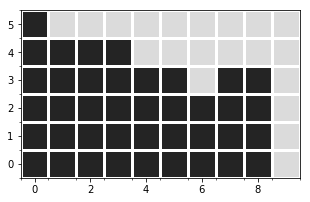

In [0]:
// Zigzag pattern
// let zigzag: [Int16] = [
//   0b10000_11111,
//   0b10000_00101,
//   0b10000_01001,
//   0b10000_10001,
//   0b10001_00001,
//   0b10010_00001,
//   0b10100_00001,
//   0b11000_00001,
//   0b00100_00000,
//   0b10010_00001,
//   0b10001_00001,
//   0b10000_10001,
//   0b10000_01001,
//   0b10000_00101,
//   0b10000_00011,
//   0b10000_00101,
//   0b10000_01001,
//   0b10000_10001,
//   0b10001_00001,
//   0b10010_00001,
//   0b10100_00001,
// ]

let typical: [Int16] = [
  0b01111_11111,
  0b01111_11111,
  0b01111_11111,
  0b01101_11111,
  0b00000_01111,
  0b00000_00001,
]

var field = Field(storage: typical, garbageCount: 0)

print(field)
draw(field)

### Try placing pieces on field

In [0]:
let piece = Piece(type: .L, x: 9, y: 3, orientation: .left)
field.canPlace(piece)
let (newField, garbageCleared) = field.lockDown(piece)
print(newField)
print("cleared garbage lines:", garbageCleared)


  X . . . . . . . . . 
  X X X X . . . . X X 
  X X X X X X . X X X 
  X X X X X X X X X . 
  X X X X X X X X X . 
cleared garbage lines: 0


# Experimentation

### MCTS search sequence

In [0]:
// Run MCTS

func performSearch(from node: Node, playSequence: [Tetromino], times: Int = 10000) {

//   var depthCount = [0]
//   var maxClears = 0
//   var maxClearNodes = [Node]()
  
  for i in 1 ... times {
//     // Okay let's start
//     if i % 1000 == 0 {
//       print("*** Round \(i) ***")
//     }
    
    // Selection & expansion)
    let (node, depth) = selectBestUnevaluatedNode(root: node)
  
    // Evaluation & backpropagation
    let playPiece = playSequence[depth + 1]
    node.setupChildren(playPiece: playPiece)
  
    let (value, priors) = evaluate(node, depth: depth)
    node.priors = priors
    backPropagate(from: node, value: value)
  
//     // Get stome statistics
//     if depth > depthCount.count - 1 {
//       print("Round \(i), max depth:", depth)
//       depthCount.append(0)
//     }
//     depthCount[depth] += 1
    
//     if node.garbageCleared > maxClears {
//       maxClears = node.garbageCleared
//       maxClearNodes.removeAll()
//       print("Round \(i), max garbage lines cleared:", maxClears)
//     }
    
//     if node.garbageCleared >= 3 && node.garbageCleared == maxClears {
//       maxClearNodes.append(node)
//     }
  }
  
//   print("Final node depths:", depthCount)
//   print()
}


### Play a game

Starting pieces: [S, L, I, T, J, Z, O, T, I, J, Z, L, S, O, L, O, Z, T, J, I, S, I, Z, O, L, S, T, J, T, Z, I, L, S, O, J, T, O, Z, S, J, L, I, S, I, L, O, Z, J, T, S, T, L, O, J, Z, I, T, O, J, L, Z, S, I, I, S, J, L, T, Z, O]


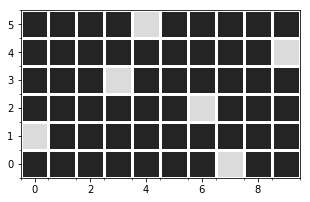

In [0]:
// Start a game

var playSequence = makeRandomPieceSequence(bags: 10)
var startField: Field = makeDigField(height: 6)
var rootNode = Node(field: startField,
                    hold: playSequence[0],
                    garbageCleared: 0)

print("Starting pieces:", playSequence)
draw(startField)
// print(rootNode)

In [0]:
// Play continuously

let originalSequenceLength = playSequence.count

while playSequence.count > 14 && rootNode.field.garbageCount > 0 {

  print("*** Move \(originalSequenceLength - playSequence.count): ***")
  
  // Do work
  performSearch(from: rootNode, playSequence: playSequence, times: 2500)
  
  // Show result
  let bestChild = rootNode.getMostVisitedChild()!
  print("Play: \(playSequence[1]), hold: \(rootNode.hold)")
  print("Play:", rootNode.legalMoves[bestChild.indexInParent])
  print(bestChild.field)
  
  // Check BCTS value
//   print("value from BCTS:", calculateBctsValue(bestChild))

  // Next!
  playSequence.removeFirst()

//   print("Preparing next step, pieces remaining:", playSequence.count)
  print()

  startField = bestChild.field
  rootNode = Node(field: startField,
                  hold: bestChild.hold,
                  garbageCleared: 0)
}

*** Move 0: ***
Play: L, hold: S
Play: 
 XXX
 X  (5, 6)

  . . . . X X X . . . 
  X X X X X X X X X .  <==
  X X X . X X X X X X 
  X X X X X X . X X X 
  . X X X X X X X X X 
  X X X X X X X . X X 

*** Move 1: ***
Play: I, hold: S
Play: 
  X
  X
  X
  X   (9, 6)

  . . . . . . . . . X 
  . . . . . . . . . X 
  . . . . X X X . . X 
  X X X . X X X X X X  <==
  X X X X X X . X X X 
  . X X X X X X X X X 
  X X X X X X X . X X 

*** Move 2: ***
Play: T, hold: S
Play: 
 X
 XX
  X    (3, 4)

  . . . . . . . . . X 
  . . X . . . . . . X 
  . . X X X X X . . X 
  X X X X X X . X X X  <==
  . X X X X X X X X X 
  X X X X X X X . X X 

*** Move 3: ***
Play: J, hold: T
Play: 
  X
  XX
  X   (0, 4)

  X . . . . . . . . X 
  X X X . . . . . . X 
  X . X X X X X . . X 
  X X X X X X . X X X  <==
  . X X X X X X X X X 
  X X X X X X X . X X 

*** Move 4: ***
Play: Z, hold: J
Play: 
 XX
  XX   (1, 5)

  X X . . . . . . . . 
  X X X . . . . . . X 
  X X X . . . . . . X 
  X . X X X X X . . X 
  X X 

### Work in progress

In [0]:
// // MCTS result

// // print(getMostTraveledPath(root: rootNode))

// print("\(maxClearNodes.count) max clear nodes at \(maxClears) lines") 

// // getReversePath(leaf: maxClearNodes[4]).enumerated().forEach { i, node in
// getMostTraveledPath(root: rootNode).enumerated().forEach { i, node in
//   if let parent = node.parent {
//     print("Move \(i): visited \(parent.childN[node.indexInParent]) times")
//     print(parent.legalMoves[node.indexInParent])
//   }
//   print("Play \(playSequence[i + 1]), hold \(node.hold)")
//   print(node.field)
//   print()
// }

In [0]:
var checkNode = rootNode
// checkNode = checkNode.getMostVisitedChild()!
print(checkNode.parent)

// print(evaluate(checkNode, depth: 0))

// print(checkNode.childW)
// print(checkNode.childN)
// print(checkNode.meanActionValue)
// print(checkNode.puctValue)
// print(checkNode.priors)
// print(checkNode.childrenActionScores)
// print()

// checkNode.legalMoves.enumerated().forEach {
//   if checkNode.childW[$0] > 0 {
//     print($1)
//   }
// }

checkNode.childN.sum()

nil


0.0
